# Imports

In [ ]:
from scripts.imports import * 

# Model params tuning and plotting (only RF)

In [ ]:
#- Tune parameters 
%run RF_tune.py #use this in terminal in different steps

In [ ]:
#- pool results
%run scripts/pool_oo.py

In [ ]:
#- plot bestparams and bestscores. For protein specific as well as average across all proteins
from scripts import plot_bestparams_bestscores 
import importlib
importlib.reload(plot_bestparams_bestscores)
_ = plot_bestparams_bestscores.plot_bestparams_pool(study='ctr')
%run scripts/plot_bestparams_bestscores.py

# GRN 

## RF

In [ ]:
# run this one from terminal, as it needs to be run in seperate sessions (1000 runs)
%run scripts/RF_GRN.py

In [ ]:
#pool the links and add oob scores to the df
%run scripts/RF_pool.py
#TODO: maybe filter the links based on high score at this stage

## Ridge

In [3]:
%run scripts/ridge_GRN.py

Data shape: (11, 34) (n_samples_time_series*n_genes)

network inference: train score, mean: 0.9912957604543623 std: 0.004365437569231246

network inference: train score, mean: 0.982941007005581 std: 0.009748522357552622


## Portia

In [ ]:
%run scripts/portia_GRN.py

## ensemble geneRNI and portia

In [ ]:
%run scripts/ensemble.py

## Plot distribution of mean weights

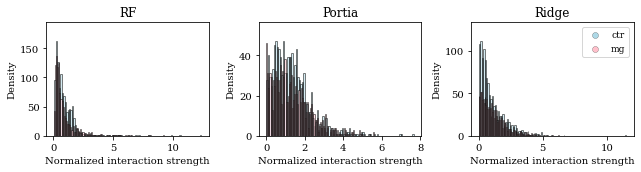

In [10]:
from scripts.imports import *
importlib.reload(utils)
links_ctr_rf, links_sample_rf = retreive_grn('ctr','rf'),retreive_grn('mg','rf')
links_ctr_portia, links_sample_portia = retreive_grn('ctr','portia'),retreive_grn('mg','portia')
links_ctr_ridge, links_sample_ridge = retreive_grn('ctr','ridge'),retreive_grn('mg','ridge')
links_combined = [[links_ctr_rf, links_sample_rf],
               [links_ctr_portia, links_sample_portia], 
               [links_ctr_ridge, links_sample_ridge]]

#- normalize

links_combined_n = [[utils.Links.nomalize(item) for item in row] for row in links_combined]
labels = ['RF','Portia',
          'Ridge']
colors = ['lightblue','pink']
utils.Links.plot_mean_weights(links_combined_n, labels, colors)

## Compare different methods: matching with string

Number of string links: 60
Number of extracted links: 100
Number of string links: 60
Number of extracted links: 100
Number of string links: 60
Number of extracted links: 100


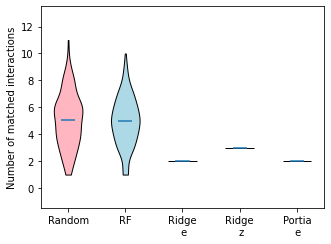

In [1]:
%run scripts/GRN_vs_string.py

## Filter

In [ ]:
%run scripts/filter_links.py

## Plot shortlisted weights

In [ ]:

def plot_weight(links, dist_key='WeightPool'):
    links_s = links.sort_values('Weight', ascending=False).reset_index(drop=True)
    
    top_n = 12
    nrows = 4
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, tight_layout=True, figsize=(ncols*3, nrows*2))
    for idx in range(top_n):
        i = int(idx/(nrows-1))
        j = idx%ncols
        ax = axes[i][j]
        ax.hist(links_s[dist_key][idx], bins=20, decay_coeff=0.5,
                        histtype='stepfilled', #'bar', 'barstacked', 'step', 'stepfilled'
                        color='lightgreen',
                        ec='black',
                        rwidth=.9
                       )
        ax.set_xlabel('Interaction strength')
        ax.set_ylabel('Model count')
#         title = links['Regulator'][idx]+'-->'+links['Target'][idx]
        title= idx
        ax.set_title(title)
        ax.set_ymargin(.15)
        ax.set_xmargin(.15)
def plot_pvalue(x):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(3, 2))
    
    ax.hist(x, bins=20, decay_coeff=0.5,
                    histtype='barstacked', #'bar', 'barstacked', 'step', 'stepfilled'
                    ec='black',
                    rwidth=.9
                   )
    ax.set_xlabel('Interaction strength')
    ax.set_ylabel('Model count')
links_short_ctr_ridge = retreive_grn('ctr','ridge')

links_target = links_short_ctr_ridge
plot_weight(links_target, dist_key='WeightPool')
# print(links_short_ctr_ensemble)

## create edges and nodes

In [ ]:
links_short_ctr_portia = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN','links_short_ctr_portia.csv'))
links_short_sample_portia = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN','links_short_mg_portia.csv'))

def process_nodes_edges(study, links, scores=None):
    #- create nodes and edges
    nodes, edges = utils.convert_links_to_nodes_edges(links, protnames, scores)
    #- output edges and nodes   
    utils.read_write_nodes_edges(nodes=nodes, edges=edges, study=study, mode='write', OUTPUT_DIR=OUTPUT_DIR)
process_nodes_edges('ctr', links_short_ctr_portia)
process_nodes_edges('mg', links_short_sample_portia)

# Vester's sensitivity analysis. 
- AS: active sum. Sum along rows of the influence matrix and it indicates how much does a variable influence all the others.
- PS: passive sum. Its is the sum along columns of the influence matrix and it indicates how sensitive a variable is, how does it react to the influence of others
- Q: AS/PS -> how dominant
- P: AS.PS -> how participative a variable is
- Active: +Q
- Passive: -Q, -P
- Critical: +Q, +P
- Buffering: -Q, -P

In [ ]:
importlib.reload(utils)
#- retreive data: short links
method = 'portia'
links_ctr = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_ctr_{method}.csv'))
links_sample = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_mg_{method}.csv'))

oo_vsa_ctr = utils.VSA.analyse(links_ctr, protnames)
oo_vsa_sample = utils.VSA.analyse(links_sample, protnames)
#- plot 1: seperate windows for ctr and sample
utils.VSA.plot_ctr_vs_sample(oo_vsa_ctr,oo_vsa_sample, protnames, OUTPUT_DIR=OUTPUT_DIR)

## Role change & plot 

In [ ]:
#- read the data
importlib.reload(utils)
# - plot 2: change in the roles 
df_role_change = utils.VSA.role_change(oo_vsa_ctr, oo_vsa_sample, target_roles=[3])
df_role_change.to_csv(os.path.join(OUTPUT_DIR,'VSA','df_role_change.csv'),index=False)
utils.VSA.plot_role_change(df_role_change, OUTPUT_DIR=OUTPUT_DIR)

# Sensitivity analysis

## multiplicative gaussian noise

In [ ]:
importlib.reload(utils)
#- retreive data
df_role_change = pd.read_csv(os.path.join(OUTPUT_DIR,'VSA','df_role_change.csv'),index_col=False)
target_prots = df_role_change['Entry'].values.tolist() 

method = 'portia'
links_ctr = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_ctr_{method}.csv'))
links_sample = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_mg_{method}.csv'))
#- multiplicative gaussian noise
# utils.SensitivityAnalysis.multiGaussNoise(links_ctr, links_sample, protnames, target_prots, OUTPUT_DIR)
#- additive gaussian noise
utils.SensitivityAnalysis.addGaussNoise(links_ctr, links_sample, protnames, target_prots, OUTPUT_DIR)

# Visualize protein network 

In [ ]:
importlib.reload(utils)
with open(os.path.join(OUTPUT_DIR, 'postprocess/map_protname_genename.json')) as f:
    map_protname_genename = json.load(f)['map']
# preferred_names = [map_protname_genename[protname] for protname in protnames]
preferred_names =protnames
def visualize(study):
    #- retreive nodes and edges
    nodes, edges = utils.read_write_nodes_edges(study=study, mode='read', OUTPUT_DIR=OUTPUT_DIR)
    utils.visualize_network(nodes, edges, 'ctr', protnames, preferred_names, OUTPUT_DIR)
visualize('ctr')

In [ ]:
import igraph
igraph.drawing.shapes.DiamondDrawer()